**Treino de um modelo com imagens que já possuem resposta correta (“gato” ou “cachorro”). Ao final, ele conseguirá classificar imagens novas pois irá aprender padrões visuais recorrentes a partir dos exemplos rotulados.**

Import das bibliotecas

In [ ]:
!pip -q install tensorflow tensorflow-datasets matplotlib

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np




In [ ]:
#parametros
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
SEED = 42


Carregar o dataset (tensorflow)

In [ ]:
(ds_train_raw, ds_val_raw), ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],
    with_info=True,
    as_supervised=True
)

print(ds_info)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.EKBR78_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings 

Pré-processamento do dataset com redimensionamento e normalização

In [ ]:
def preprocess(image, label):
    # evita tamanhos variados
    image = tf.image.resize(image, IMG_SIZE)

    image = tf.cast(image, tf.float32) / 255.0

    return image, label

ds_train = ds_train_raw.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val   = ds_val_raw.map(preprocess,   num_parallel_calls=tf.data.AUTOTUNE)

ds_train = ds_train.shuffle(2000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val   = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)




Ex. das imagens rotuladas

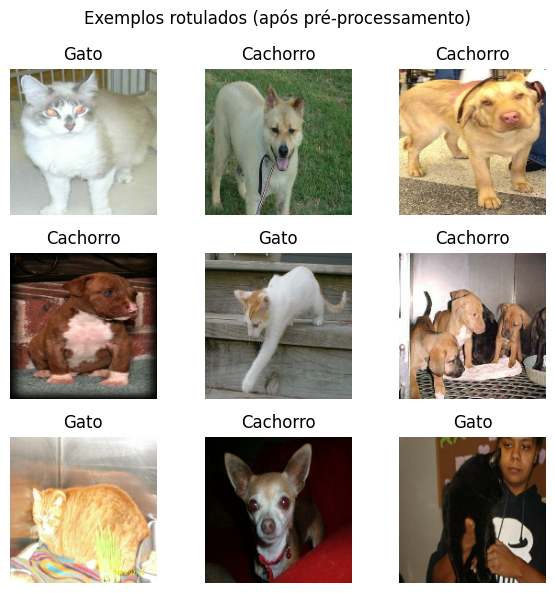

In [ ]:
plt.figure(figsize=(6, 6))

for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])  # já está 0..1 e 160x160
        plt.title("Cachorro" if int(labels[i]) == 1 else "Gato")
        plt.axis("off")

plt.suptitle("Exemplos rotulados (após pré-processamento)")
plt.tight_layout()
plt.show()



Modelo de classificação

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),
    tf.keras.layers.Conv2D(16, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")  # binário: 0 gato, 1 cachorro
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,327,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,350,817 (5.15 MB)

 Trainable params: 1,350,817 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

Treinamento

In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=5
)



Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 529s 893ms/step - accuracy: 0.6073 - loss: 0.6547 - val_accuracy: 0.7229 - val_loss: 0.5562
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 491s 837ms/step - accuracy: 0.7451 - loss: 0.5101 - val_accuracy: 0.7571 - val_loss: 0.4993
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 477s 814ms/step - accuracy: 0.8042 - loss: 0.4214 - val_accuracy: 0.7951 - val_loss: 0.4427
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 481s 819ms/step - accuracy: 0.8497 - loss: 0.3407 - val_accuracy: 0.8057 - val_loss: 0.4440
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 486s 830ms/step - accuracy: 0.8883 - loss: 0.2606 - val_accuracy: 0.8128 - val_loss: 0.4714


Visualizar aprendizado supervisiondo

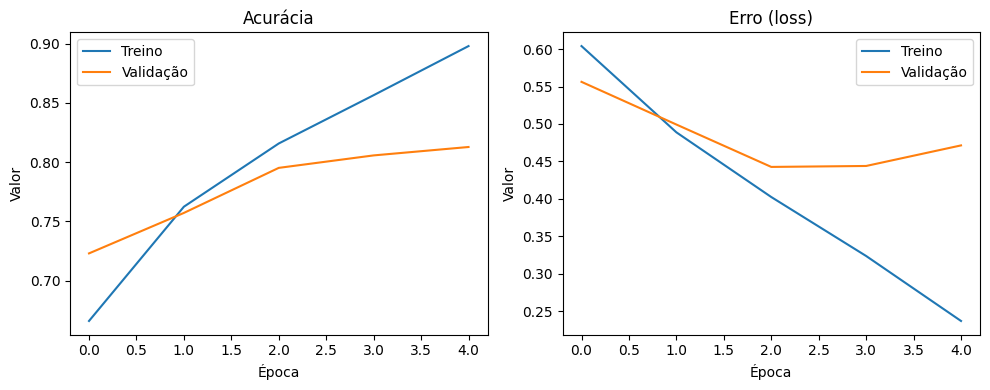

In [ ]:
plt.figure(figsize=(10, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Treino")
plt.plot(history.history["val_accuracy"], label="Validação")
plt.title("Acurácia")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Treino")
plt.plot(history.history["val_loss"], label="Validação")
plt.title("Erro (loss)")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.legend()

plt.tight_layout()
plt.show()



*Os gráficos mostram que o modelo aprende progressivamente nas primeiras épocas, com melhora consistente da acurácia e redução do erro. A estabilização da validação nas últimas épocas indica um limite natural de generalização para essa arquitetura simples.*

Reconhece se a imagem é de um "gato"

In [ ]:
#função de previsão
def reconhecer_gato(image):
    # Garante tamanho fixo
    image = tf.image.resize(image, IMG_SIZE)

    # Garante float32
    image = tf.cast(image, tf.float32)

    # Normaliza apenas se vier no formato 0..255
    if tf.reduce_max(image) > 1.0:
        image = image / 255.0

    image = tf.expand_dims(image, 0)  # (1, H, W, 3)

    prob_dog = float(model.predict(image, verbose=0)[0][0])  # classe 1 = cachorro
    if prob_dog < 0.5:
        return "Gato", 1 - prob_dog
    else:
        return "Cachorro", prob_dog



Teste do modelo em imagens reais

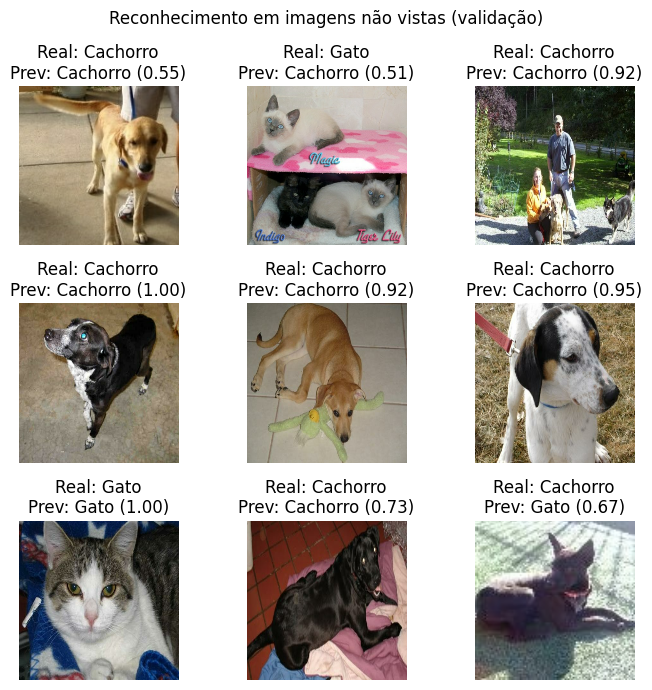

In [ ]:
plt.figure(figsize=(7, 7))

for images, labels in ds_val.take(1):
    for i in range(9):
        img = images[i]
        real = "Cachorro" if int(labels[i]) == 1 else "Gato"
        pred, conf = reconhecer_gato(img)

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Real: {real}\nPrev: {pred} ({conf:.2f})")
        plt.axis("off")

plt.suptitle("Reconhecimento em imagens não vistas")
plt.tight_layout()
plt.show()


## O modelo apresentou **bom desempenho geral** ao classificar imagens não vistas, com a maioria das previsões corretas. Os erros observados ocorreram em casos visualmente ambíguos, nos quais a probabilidade prevista ficou próxima do limiar de decisão, indicando incerteza do modelo. **Esse comportamento é esperado para uma rede convolucional simples treinada por poucas épocas, sem técnicas avançadas de otimização ou transferência de aprendizado.** Os resultados mostram que o modelo aprendeu padrões visuais relevantes, mas ainda possui limitações naturais de generalização, evidenciando que o aprendizado é estatístico e dependente da qualidade e diversidade dos dados.
